In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

torch.manual_seed(42)

In [2]:
import cudf as cd
import numpy as np

df = cd.read_csv("aapl_5y.csv")
df = df.fillna(0)
df["volume"] = df["volume"].astype(float)
scaler = MinMaxScaler((0,1))
df.drop("Date", inplace=True, axis=1)
df.head()

,open,high,low,close,volume,dividends,stock splits,sma_50,ema_50,macd,...,bb_lower,roc,hi_lo,hi_close,lo_close,true_range,ATR,obv,%K,%D
0,63.908287,64.417267,63.745903,64.412422,100206400.0,0.0,0.0,0.0,64.412422,0.000000,...,0.0,0.0,0.671364,0.000000,0.000000,0.671364,0.0,0.000000,0.0,0.0
1,64.422112,64.817177,64.041595,64.737198,86703200.0,0.0,0.0,0.0,64.425158,0.025908,...,0.0,0.0,0.775582,0.404755,0.370827,0.775582,0.0,0.005042,0.0,0.0
2,64.931084,64.955322,64.322739,64.540871,76167200.0,0.0,0.0,0.0,64.429696,0.030250,...,0.0,0.0,0.632584,0.218124,0.414459,0.632584,0.0,0.008075,0.0,0.0
3,64.359085,64.489960,63.113297,63.789513,106234400.0,0.0,0.0,0.0,64.404591,-0.026631,...,0.0,0.0,1.376663,0.050911,1.427574,1.427574,0.0,0.019716,0.0,0.0
4,63.910725,63.988285,63.302372,63.503544,121395200.0,0.0,0.0,0.0,64.369256,-0.093704,...,0.0,0.0,0.685913,0.198773,0.487141,0.685913,0.0,0.024199,0.0,0.0


In [3]:
close = df["close"].to_numpy()
tsa = seasonal_decompose(close, model="additive", period=180)
df["trend"] = tsa.trend
df["seasonal"] = tsa.seasonal
df["residual"] = tsa.resid
df = df.fillna(0)

In [6]:
features = df[['volume', 'macd_hist', "macd", "signal_line", "%K", "%D", "ema_50",
       'rsi', "roc", 'bb_upper', 'bb_lower']]
targets = df[["trend","seasonal","residual"]]

In [7]:
train_size = int(0.8 * len(features))
X_train_set = features.iloc[:train_size, :]
X_test_set = features.iloc[train_size:, :]

y_train_set = targets.iloc[:train_size, :]
y_test_set = targets.iloc[train_size:, :]

X_train_set = scaler.fit_transform(X_train_set.fillna(np.nan).to_numpy())
X_test_set = scaler.transform(X_test_set.fillna(np.nan).to_numpy())

y_train_set = scaler.fit_transform(y_train_set.fillna(np.nan).to_numpy())
y_test_set = scaler.transform(y_test_set.fillna(np.nan).to_numpy())

In [8]:
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TensorDataset(torch.from_numpy(X_train_set).float().to(device))
test_dataset = TensorDataset(torch.from_numpy(X_test_set).float().to(device))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
train_size = int(features.shape[0] * 0.8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.from_numpy(X_train_set).float().to(device)
X_test = torch.from_numpy(X_test_set).float().to(device)
y_train = torch.from_numpy(y_train_set).float().to(device)
y_test = torch.from_numpy(y_test_set).float().to(device)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, out_size):
        super(LSTM, self).__init__()
        df["close"].shape
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True,device="cuda")
        self.fc = nn.Linear(hidden_size, out_size, device="cuda")

    def forward(self,x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device="cuda")
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device="cuda")

        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])

        return out

In [11]:
model = LSTM(11,256,3,3).to(device = "cuda")

In [12]:
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -1.0, 1.0))

In [13]:
sequence_length = 20

X_train = [X_train[i:i + sequence_length] for i in range(len(X_train) - sequence_length + 1)]
X_test = [X_test[i:i + sequence_length] for i in range(len(X_test) - sequence_length + 1)]

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

y_train = y_train[sequence_length-1:]
y_test = y_test[sequence_length-1:]

In [14]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_train)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [15]:
# My training loop

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 5e-3)

epochs = 10000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train).squeeze()
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch} / {epochs}], Loss: {loss.item():.4f}")

Epoch [9 / 10000], Loss: 0.1635
Epoch [19 / 10000], Loss: 0.0608
Epoch [29 / 10000], Loss: 0.0546
Epoch [39 / 10000], Loss: 0.0517
Epoch [49 / 10000], Loss: 0.0504
Epoch [59 / 10000], Loss: 0.0492
Epoch [69 / 10000], Loss: 0.0466
Epoch [79 / 10000], Loss: 0.0437
Epoch [89 / 10000], Loss: 0.0367
Epoch [99 / 10000], Loss: 0.0291
Epoch [109 / 10000], Loss: 0.0264
Epoch [119 / 10000], Loss: 0.0252
Epoch [129 / 10000], Loss: 0.0237
Epoch [139 / 10000], Loss: 0.0272
Epoch [149 / 10000], Loss: 0.0249
Epoch [159 / 10000], Loss: 0.0228
Epoch [169 / 10000], Loss: 0.0208
Epoch [179 / 10000], Loss: 0.0203
Epoch [189 / 10000], Loss: 0.0281
Epoch [199 / 10000], Loss: 0.0213
Epoch [209 / 10000], Loss: 0.0184
Epoch [219 / 10000], Loss: 0.0167
Epoch [229 / 10000], Loss: 0.0152
Epoch [239 / 10000], Loss: 0.0136
Epoch [249 / 10000], Loss: 0.0148
Epoch [259 / 10000], Loss: 0.0155
Epoch [269 / 10000], Loss: 0.0127
Epoch [279 / 10000], Loss: 0.0192
Epoch [289 / 10000], Loss: 0.0143
Epoch [299 / 10000], Loss

KeyboardInterrupt: 

In [16]:
# Assuming X_test shape is (233, 20, 23)
# Make sure that the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    y_pred = model(X_test)

# If needed, reshape to (233, 1) - check if it's already the correct shape# This will ensure the shape is (233, 1)


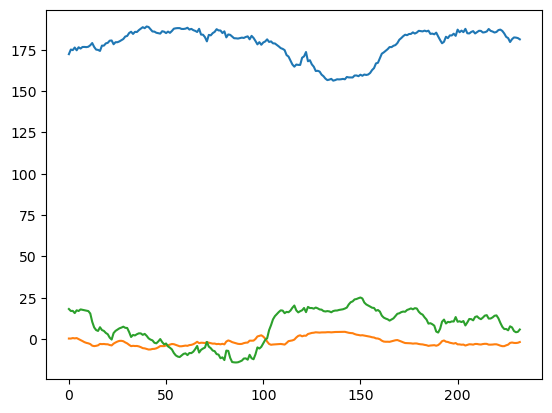

In [17]:
import matplotlib.pyplot as plt

y_pred = y_pred.cpu().numpy()
y_pred = scaler.inverse_transform(y_pred)
plt.plot(range(0,y_pred.shape[0]),y_pred[:,0])
plt.plot(range(0,y_pred.shape[0]),y_pred[:,1])
plt.plot(range(0,y_pred.shape[0]),y_pred[:,2])

In [18]:
predicted_stock = y_pred[:,0] + y_pred[:,1] + y_pred[:,2]

In [19]:
predicted_stock.shape

(233,)

In [24]:
X_test.shape

torch.Size([233, 20, 11])

In [27]:
df["close"].shape[0] - train_size

252

In [29]:
close = df["close"]
close = close.iloc[df["close"].shape[0]-X_test.shape[0]:]
close

1025    196.994919
1026    197.144180
1027    196.606827
1028    194.935013
1029    195.979889
           ...    
1253    226.960007
1254    224.229996
1255    224.229996
1256    225.119995
1257    228.220001
Name: close, Length: 233, dtype: float64

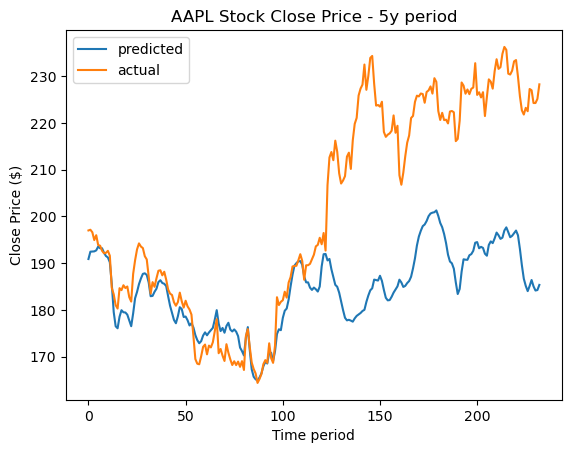

In [30]:
plt.plot(range(0,y_pred.shape[0]),predicted_stock, label = "predicted")
plt.plot(range(0,close.shape[0]), close, label = "actual")
plt.title("AAPL Stock Close Price - 5y period")
plt.ylabel("Close Price ($)")
plt.xlabel("Time period")
plt.legend()
plt.show()

In [ ]:
df.iloc[train_size:]

,open,high,low,close,volume,dividends,stock splits,sma_50,ema_50,macd,...,hi_close,lo_close,true_range,ATR,obv,%K,%D,trend,seasonal,residual
1006,186.934221,188.576171,186.864555,187.093430,53790500.0,0.00,0.0,175.365985,177.317815,3.020636,...,2.049957,0.338340,2.049957,3.146709,15.138171,93.804032,94.155146,182.169850,-6.315072,11.238652
1007,188.645839,190.029062,187.730311,188.785156,54412900.0,0.00,0.0,175.612451,177.767515,3.408417,...,2.935633,0.636882,2.935633,3.161811,15.147214,95.099575,95.315533,182.082461,-5.864017,12.566712
1008,189.322496,189.451867,187.650693,188.765228,50922700.0,0.00,0.0,175.846195,178.198797,3.671803,...,0.666711,1.134463,1.801173,3.111742,15.147319,95.021068,94.641558,181.979212,-5.086565,11.872581
1009,188.964270,190.974427,188.954324,190.516663,46505100.0,0.00,0.0,176.091513,178.681851,3.976031,...,2.209198,0.189096,2.209198,3.019463,15.156597,98.261369,96.127337,181.866120,-4.733481,13.384023
1010,190.476852,190.586317,188.814996,189.710602,38134500.0,0.00,0.0,176.381531,179.114351,4.104774,...,0.069654,1.701667,1.771321,2.997716,15.160828,95.199876,96.160771,181.742465,-6.083638,14.051774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,227.169998,228.660004,226.410004,226.960007,38328800.0,0.25,0.0,226.575316,226.220748,-0.789405,...,1.430008,0.819992,2.250000,4.010711,17.679178,42.180566,34.270140,0.000000,4.439298,0.000000
1254,225.000000,225.699997,221.500000,224.229996,42005600.0,0.00,0.0,226.484949,226.142679,-0.937072,...,1.260010,5.460007,5.460007,4.074941,17.691207,26.809276,37.563526,0.000000,4.411052,0.000000
1255,224.550003,225.589996,223.360001,224.229996,40398300.0,0.00,0.0,226.519046,226.067672,-1.042087,...,1.360001,0.869995,2.229996,3.877281,17.691207,26.809276,31.933039,0.000000,5.483545,0.000000
1256,224.009995,226.649994,222.759995,225.119995,48566200.0,0.00,0.0,226.609300,226.030508,-1.041490,...,2.419998,1.470001,3.889999,3.871501,17.695176,33.008552,28.875701,0.000000,5.689466,0.000000


: 

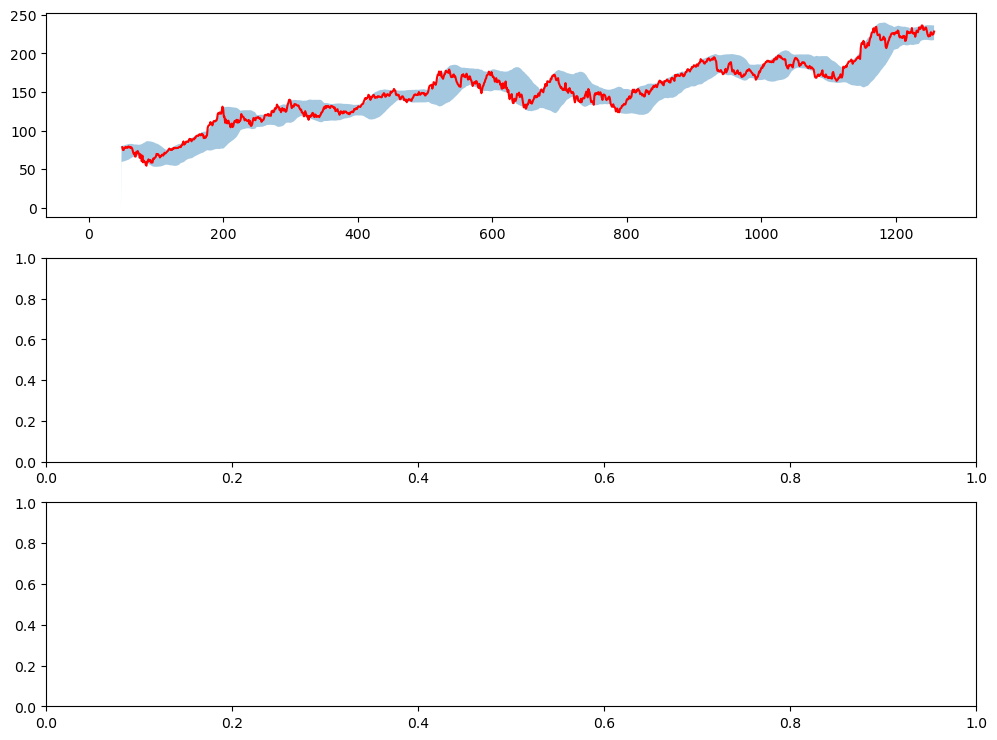

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.plot(range(50,len(df["close"])), df["close"].iloc[50:].to_numpy(), c='r')
ax1.fill_between(range(0,len(df["close"])), y1=df["bb_lower"].to_numpy(), y2=df["bb_upper"].to_numpy(), alpha=0.4)
ax2.plot()
fig.set_size_inches(12,9)

In [55]:
len(predicted_stock)

1211

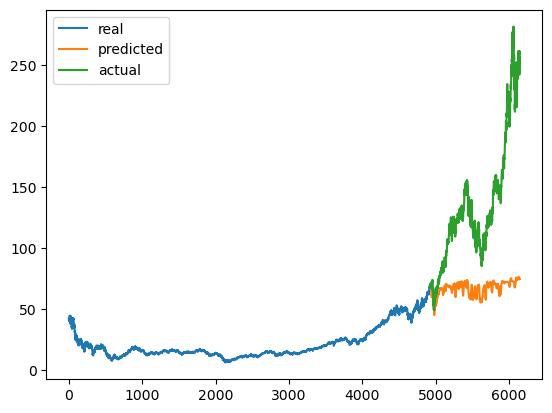

: 

In [ ]:
plt.plot(range(0,len(df["close"])-1211),df["close"].to_numpy()[:len(df["close"])-1211], label = "real")
plt.plot(range(len(df["close"])-1211, len(df["close"])), predicted_stock, label="predicted")
plt.plot(range(len(df["close"])-1230, len(df["close"])), close, label="actual")
plt.legend()
plt.show()